In [1]:
!python -V

Python 3.9.2


In [2]:
from func_utils import load_dtypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import missingno as msno
from collections import Counter
%matplotlib inline

In [3]:
data_types = load_dtypes()

In [4]:
df = pd.read_csv('../data/raw/train.csv.gz', 
                 compression='gzip', 
                 dtype=data_types)

In [5]:
df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [6]:
df.shape

(8921483, 83)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   MachineIdentifier                                  category
 1   ProductName                                        category
 2   EngineVersion                                      category
 3   AppVersion                                         category
 4   AvSigVersion                                       category
 5   IsBeta                                             int8    
 6   RtpStateBitfield                                   float16 
 7   IsSxsPassiveMode                                   int8    
 8   DefaultBrowsersIdentifier                          float16 
 9   AVProductStatesIdentifier                          float32 
 10  AVProductsInstalled                                float16 
 11  AVProductsEnabled                    

## Feature groups:

#### 1. Machine specs and OS:
- MachineIdentifier - Individual machine ID
- HasTpm - True if machine has tpm Trusted Platform Module (TPM)
- Platform - Calculates platform name (of OS related properties and processor property)
- Processor - This is the process architecture of the installed operating system
- OsVer - Version of the current operating system
- OsBuild - Build of the current operating system
- OsSuite - Product suite mask for the current operating system
- OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
- OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
- SkuEdition - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.

#### 2. Defender Specs:    
- ProductName - Defender state information e.g. win8defender
- EngineVersion - Defender state information e.g. 1.1.12603.0
- AppVersion - Defender state information e.g. 4.9.10586.0
- AvSigVersion - Defender state information e.g. 1.217.1014.0
- IsBeta - Defender state information e.g. false
 
#### 3. Anti Virus (AV) & Security Settings:
- AVProductStatesIdentifier - ID for the specific configuration of a  user's antivirus software
- AVProductsInstalled - NA
- AVProductsEnabled - NA
- IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
- PuaMode - Pua Enabled mode from the service
- SMode - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
- SmartScreen - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry. This helps you identify reported phishing and malware websites and also helps you make informed decisions about downloads. 
- Firewall - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
- UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.+

#### 4. Browser & Apps:
- DefaultBrowsersIdentifier - ID for the machine's default browser
- IeVerIdentifier - NA - Should be Internet Explorer Version
- Wdft_IsGamer - Indicates whether the device is a gamer device or not based on its hardware combination.

#### 5. Geographical:
- CountryIdentifier - ID for the country the machine is located in
- CityIdentifier - ID for the city the machine is located in
- OrganizationIdentifier - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
- GeoNameIdentifier - ID for the geographic region a machine is located in
- LocaleEnglishNameIdentifier - English name of Locale ID of the current user

#### 6. Census Data:
- Census_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
- Census_DeviceFamily - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
- Census_OEMNameIdentifier - NA
- Census_OEMModelIdentifier - NA
- Census_ProcessorCoreCount - Number of logical cores in the processor
- Census_ProcessorManufacturerIdentifier - NA
- Census_ProcessorModelIdentifier - NA
- Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
- Census_PrimaryDiskTotalCapacity - Amount of disk space on primary disk of the machine in MB
- Census_PrimaryDiskTypeName - Friendly name of Primary Disk Type - HDD or SSD
- Census_SystemVolumeTotalCapacity - The size of the partition that the System volume is installed on in MB
- Census_HasOpticalDiskDrive - True indicates that the machine has an optical disk drive (CD/DVD)
- Census_TotalPhysicalRAM - Retrieves the physical RAM in MB
- Census_ChassisTypeName - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
- Census_InternalPrimaryDiagonalDisplaySizeInInches - Retrieves the physical diagonal length in inches of the primary display
- Census_InternalPrimaryDisplayResolutionHorizontal - Retrieves the number of pixels in the horizontal direction of the internal display.
- Census_InternalPrimaryDisplayResolutionVertical - Retrieves the number of pixels in the vertical direction of the internal display
- Census_PowerPlatformRoleName - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
- Census_InternalBatteryType - NA
- Census_InternalBatteryNumberOfCharges - NA
- Census_OSVersion - Numeric OS version Example - 10.0.10130.0
- Census_OSArchitecture - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
- Census_OSBranch - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005
- Census_OSBuildNumber - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
- Census_OSBuildRevision - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
- Census_OSEdition - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
- Census_OSSkuName - OS edition friendly name (currently Windows only)
- Census_OSInstallTypeName - Friendly description of what install was used on the machine i.e. clean
- Census_OSInstallLanguageIdentifier - NA
- Census_OSUILocaleIdentifier - NA
- Census_OSWUAutoUpdateOptionsName - Friendly name of the WindowsUpdate auto-update settings on the machine.
- Census_IsPortableOperatingSystem - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
- Census_GenuineStateName - Friendly name of OSGenuineStateID. 0 = Genuine
- Census_ActivationChannel - Retail license key or Volume license key for a machine.
- Census_IsFlightingInternal - NA
- Census_IsFlightsDisabled - Indicates if the machine is participating in flighting.
- Census_FlightRing - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
- Census_ThresholdOptIn - NA
- Census_FirmwareManufacturerIdentifier - NA
- Census_FirmwareVersionIdentifier - NA
- Census_IsSecureBootEnabled - Indicates if Secure Boot mode is enabled.
- Census_IsWIMBootEnabled - NA
- Census_IsVirtualDevice - Identifies a Virtual Machine (machine learning model)
- Census_IsTouchEnabled - Is this a touch device ?
- Census_IsPenCapable - Is the device capable of pen input ?
- Census_IsAlwaysOnAlwaysConnectedCapable - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .

#### 7. Unknown:
- RtpStateBitfield - NA
- IsSxsPassiveMode - NA
- AutoSampleOptIn - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9
- UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.+

In [8]:
round(df.HasDetections.mean(), 2), df.HasDetections.isnull().sum()

(0.5, 0)

In [9]:
df.HasDetections.value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

The dataset is balanced and there are no missing values in the target variable.

Check missing values:

In [10]:
missing_df = pd.concat([df.isnull().sum(), round(df.isnull().mean() * 100, 2)], axis=1)
missing_df.columns = ['missing_count', '%']
missing_df.sort_values(by='missing_count', ascending=False)[:15]

,missing_count,%
PuaMode,8919174,99.97
Census_ProcessorClass,8884852,99.59
DefaultBrowsersIdentifier,8488045,95.14
Census_IsFlightingInternal,7408759,83.04
Census_InternalBatteryType,6338429,71.05
Census_ThresholdOptIn,5667325,63.52
Census_IsWIMBootEnabled,5659703,63.44
SmartScreen,3177011,35.61
OrganizationIdentifier,2751518,30.84
SMode,537759,6.03


In [11]:
missing_list = missing_df[missing_df['%']>40].index.tolist()
missing_list

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

In [12]:
df[missing_list].nunique()

DefaultBrowsersIdentifier     1730
PuaMode                          2
Census_ProcessorClass            3
Census_InternalBatteryType      78
Census_IsFlightingInternal       2
Census_ThresholdOptIn            2
Census_IsWIMBootEnabled          2
dtype: int64

Drop variables with missing values > 40%

In [13]:
df = df.drop(missing_list, axis=1)

Check for duplicates:

In [14]:
df.duplicated(keep=False).sum()

0

In [15]:
df['MachineIdentifier'].nunique(), df.shape[0]

(8921483, 8921483)

Get rid of MachineIdentifier:

In [16]:
df = df.drop('MachineIdentifier', axis=1)

In [17]:
df.shape

(8921483, 75)

# Categorical Features

In [18]:
cat_col = df.select_dtypes('category').columns.tolist()
df[cat_col].head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,...,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,...,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,UNKNOWN,IS_GENUINE,Retail,Retail
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,...,10.0.17134.1,amd64,rs4_release,Professional,PROFESSIONAL,IBSClean,UNKNOWN,OFFLINE,Retail,NOT_SET
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,...,10.0.17134.165,amd64,rs4_release,Core,CORE,UUPUpgrade,FullAuto,IS_GENUINE,OEM:NONSLP,Retail
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,...,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:NONSLP,Retail
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,...,10.0.17134.191,amd64,rs4_release,Core,CORE,Update,FullAuto,IS_GENUINE,Retail,Retail


In [19]:
df[cat_col].describe().T

,count,unique,top,freq
ProductName,8921483,6,win8defender,8826520
EngineVersion,8921483,70,1.1.15200.1,3845067
AppVersion,8921483,110,4.18.1807.18075,5139224
AvSigVersion,8921483,8531,1.273.1420.0,102317
Platform,8921483,4,windows10,8618715
Processor,8921483,3,x64,8105435
OsVer,8921483,58,10.0.0.0,8632545
OsPlatformSubRelease,8921483,9,rs4,3915526
OsBuildLab,8921462,663,17134.1.amd64fre.rs4_release.180410-1804,3658199
SkuEdition,8921483,8,Home,5514341


In [20]:
for col in cat_col:
    print(f'''
Feature: {col} 
Unique Values Count: {df[col].nunique()}
Missing Values Count: {df[col].isnull().sum()}
Value counts: 
{df[col].value_counts()}
''')   


Feature: ProductName 
Unique Values Count: 6
Missing Values Count: 0
Value counts: 
win8defender     8826520
mse                94873
mseprerelease         53
scep                  22
windowsintune          8
fep                    7
Name: ProductName, dtype: int64


Feature: EngineVersion 
Unique Values Count: 70
Missing Values Count: 0
Value counts: 
1.1.15200.1    3845067
1.1.15100.1    3675915
1.1.15000.2     265218
1.1.14901.4     212408
1.1.14600.4     160585
                ...   
1.1.13301.0          2
1.1.11202.0          1
1.1.11104.0          1
1.1.12802.0          1
1.1.10701.0          1
Name: EngineVersion, Length: 70, dtype: int64


Feature: AppVersion 
Unique Values Count: 110
Missing Values Count: 0
Value counts: 
4.18.1807.18075    5139224
4.18.1806.18062     850929
4.12.16299.15       359871
4.10.209.0          272455
4.13.17134.1        257270
                    ...   
4.5.212.0                1
4.13.17134.226           1
4.7.209.0                1
4.8.10240.17943


Feature: Census_OSArchitecture 
Unique Values Count: 3
Missing Values Count: 0
Value counts: 
amd64    8105885
x86       815252
arm64        346
Name: Census_OSArchitecture, dtype: int64


Feature: Census_OSBranch 
Unique Values Count: 32
Missing Values Count: 0
Value counts: 
rs4_release                  4009158
rs3_release                  1237321
rs3_release_svc_escrow       1199767
rs2_release                   797066
rs1_release                   785534
th2_release                   326655
th2_release_sec               266882
th1_st1                       195840
th1                            75764
rs5_release                    15324
rs3_release_svc_escrow_im       6181
rs_prerelease                   3171
rs_prerelease_flt               2714
rs5_release_sigma                 62
rs1_release_srvmedia              10
winblue_ltsb_escrow                8
win7sp1_ldr                        3
win8_gdr                           3
winblue_ltsb                       3
rs5_release_sigma_

Some categorical variables have rare classes, other have lots of classes equally frequent. Let's look at these high cardinality featurtes more in detail.

In [21]:
n_unique_list = df[cat_col].nunique().sort_values(ascending=False)
n_unique_list[:20]

AvSigVersion                        8531
OsBuildLab                           663
Census_OSVersion                     469
AppVersion                           110
EngineVersion                         70
OsVer                                 58
Census_ChassisTypeName                52
Census_OSEdition                      33
Census_OSBranch                       32
Census_OSSkuName                      30
SmartScreen                           21
Census_MDC2FormFactor                 13
Census_PowerPlatformRoleName          10
Census_FlightRing                     10
Census_OSInstallTypeName               9
OsPlatformSubRelease                   9
SkuEdition                             8
Census_OSWUAutoUpdateOptionsName       6
Census_ActivationChannel               6
ProductName                            6
dtype: int64

<AxesSubplot:>

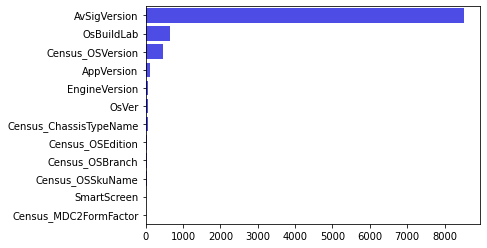

In [22]:
high_cardinality_features = n_unique_list[n_unique_list > 10]
sns.barplot(y=high_cardinality_features.index, 
            x=high_cardinality_features.values, 
            orient='h', 
            color='b', 
            alpha=.8)

#### AvSigVersion

In [23]:
av_sig_ver = pd.concat([df['AvSigVersion'].value_counts(),
                        df['AvSigVersion'].value_counts()/df.shape[0]*100], 
                        axis=1)
av_sig_ver.columns=['Count', '%']
av_sig_ver.head(20)

,Count,%
1.273.1420.0,102317,1.146861
1.263.48.0,98024,1.098741
1.275.1140.0,97232,1.089864
1.275.727.0,92448,1.036240
1.273.371.0,86967,0.974804
1.273.1826.0,86013,0.964111
1.275.1244.0,78902,0.884405
1.251.42.0,76837,0.861258
1.275.1209.0,66393,0.744192
1.273.810.0,65895,0.738610


In [24]:
idx = df['AvSigVersion'][~df.AvSigVersion.str.startswith('1')].index
df['AvSigVersion'].loc[idx]

110258     0.0.0.0
152561     0.0.0.0
165482     0.0.0.0
475422     0.0.0.0
549779     0.0.0.0
            ...   
8261662    0.0.0.0
8361401    0.0.0.0
8394149    0.0.0.0
8566717    0.0.0.0
8602753    0.0.0.0
Name: AvSigVersion, Length: 68, dtype: category
Categories (8531, object): ['1.221.14.0', '1.225.1459.0', '1.225.1590.0', '1.225.191.0', ..., '1.217.500.0', '1.203.1966.0', '1.213.1918.0', '1.223.1075.0']

In [25]:
df['AvSigVersion_extracted'] = [item[1] for item in df.AvSigVersion.str.split('.')]
df['AvSigVersion_extracted'] = df['AvSigVersion_extracted'].astype('category')
df[['AvSigVersion','AvSigVersion_extracted']]

,AvSigVersion,AvSigVersion_extracted
0,1.273.1735.0,273
1,1.263.48.0,263
2,1.273.1341.0,273
3,1.273.1527.0,273
4,1.273.1379.0,273
...,...,...
8921478,1.273.1555.0,273
8921479,1.233.4218.0,233
8921480,1.275.1242.0,275
8921481,1.269.1834.0,269


In [26]:
to_drop = []
to_drop.append('AvSigVersion')

This feature requires some engineering. Here I extracted features from strings. I'll perform roll up encoding to reduce cardinality later in paralle with EDA.

#### Census_OSVersion

In [27]:
census_os_ver = pd.concat([df['Census_OSVersion'].value_counts(),
                        df['Census_OSVersion'].value_counts()/df.shape[0]*100], 
                        axis=1)
census_os_ver.columns=['Count', '%']
census_os_ver.head(20)

,Count,%
10.0.17134.228,1413627,15.845202
10.0.17134.165,899711,10.084770
10.0.16299.431,546546,6.126179
10.0.17134.285,470280,5.271321
10.0.16299.547,346853,3.887840
10.0.17134.112,346410,3.882875
10.0.16299.371,325267,3.645885
10.0.17134.191,228254,2.558476
10.0.14393.2189,223775,2.508271
10.0.16299.611,216776,2.429820


In [28]:
sum(~df.Census_OSVersion.str.startswith('10.0.'))

20

In [29]:
idx = df['Census_OSVersion'][~df.Census_OSVersion.str.startswith('10')].index
df['Census_OSVersion'].loc[idx]

539238     6.3.9600.19102
570167     6.1.7601.24241
667694     6.2.9200.17617
1370982    6.3.9600.19069
1485064    6.3.9600.19069
1549235    6.2.9200.17617
2927703    6.2.9200.17581
3183570    6.3.9600.18687
3336222    6.3.9600.19102
4035016    6.1.7601.24149
4813273    6.3.9600.19102
5593621    6.3.9600.19069
5889449    6.3.9600.18778
6422191    6.1.7601.24241
6758081    6.1.7601.24214
6895980    6.3.9600.18756
7611545    6.1.7601.23418
8266291    6.3.9600.19069
8370072    6.3.9600.19102
8743609    6.2.9200.21703
Name: Census_OSVersion, dtype: category
Categories (469, object): ['10.0.10240.16384', '10.0.10240.16397', '10.0.10240.16405', '10.0.10240.16413', ..., '6.2.9200.21703', '10.0.14466.228', '10.0.16299.183', '10.0.17750.1000']

In [30]:
len(idx)

20

OS Version 6 is rare, just 20 cases. All the others are ver 10.0. 
Of these we can extract the 5-digit version code after "10.0.".  

In [31]:
df['Census_OSVersion_extracted'] = [item[2] for item in df.Census_OSVersion.str.split('.')]
df['Census_OSVersion_extracted'] = df['Census_OSVersion_extracted'].astype('category')
df[['Census_OSVersion', 'Census_OSVersion_extracted']]

,Census_OSVersion,Census_OSVersion_extracted
0,10.0.17134.165,17134
1,10.0.17134.1,17134
2,10.0.17134.165,17134
3,10.0.17134.228,17134
4,10.0.17134.191,17134
...,...,...
8921478,10.0.16299.431,16299
8921479,10.0.10586.679,10586
8921480,10.0.16299.371,16299
8921481,10.0.15063.483,15063


In [32]:
to_drop.append('Census_OSVersion')

#### AppVersion

In [33]:
app_ver = pd.concat([df['AppVersion'].value_counts(),
                        df['AppVersion'].value_counts()/df.shape[0]*100], 
                        axis=1)
app_ver.columns=['Count', '%']
app_ver.head(20)

,Count,%
4.18.1807.18075,5139224,57.605042
4.18.1806.18062,850929,9.537977
4.12.16299.15,359871,4.033758
4.10.209.0,272455,3.053921
4.13.17134.1,257270,2.883713
4.16.17656.18052,235032,2.634450
4.13.17134.228,226501,2.538827
4.8.10240.17443,205480,2.303205
4.9.10586.1106,203525,2.281291
4.14.17639.18041,194699,2.182361


In [34]:
idx = df['AppVersion'][~df.AppVersion.str.startswith('4')].index
df['AppVersion'].loc[idx]

Series([], Name: AppVersion, dtype: category
Categories (110, object): ['4.10.14393.0', '4.10.14393.1066', '4.10.14393.1198', '4.10.14393.1593', ..., '4.13.17618.1000', '4.12.16299.0', '4.8.10240.17943', '4.13.17604.1000'])

The AppVersion is always 4, I'll extract subversions after "4.".

In [35]:
df['AppVersion_extracted'] = [item[1] for item in df.AppVersion.str.split('.')]
df['AppVersion_extracted'] = df['AppVersion_extracted'].astype('category')
df[['AppVersion','AppVersion_extracted']]

,AppVersion,AppVersion_extracted
0,4.18.1807.18075,18
1,4.13.17134.1,13
2,4.18.1807.18075,18
3,4.18.1807.18075,18
4,4.18.1807.18075,18
...,...,...
8921478,4.18.1807.18075,18
8921479,4.9.10586.672,9
8921480,4.18.1807.18075,18
8921481,4.16.17656.18052,16


In [36]:
to_drop.append('AppVersion')

#### EngineVersion

In [37]:
eng_ver = pd.concat([df['EngineVersion'].value_counts(),
                     df['EngineVersion'].value_counts()/df.shape[0]*100], 
                     axis=1)
eng_ver.columns=['Count', '%']
eng_ver.head(20)

,Count,%
1.1.15200.1,3845067,43.098967
1.1.15100.1,3675915,41.202959
1.1.15000.2,265218,2.972802
1.1.14901.4,212408,2.380860
1.1.14600.4,160585,1.799981
1.1.14800.3,136476,1.529746
1.1.15300.6,120295,1.348374
1.1.14104.0,93926,1.052807
1.1.13504.0,70645,0.791853
1.1.15300.5,68716,0.770231


In [38]:
idx = df['EngineVersion'][~df.EngineVersion.str.startswith('1.1.')].index
df['EngineVersion'].loc[idx]

Series([], Name: EngineVersion, dtype: category
Categories (70, object): ['1.1.12805.0', '1.1.12902.0', '1.1.13000.0', '1.1.13103.0', ..., '1.1.11202.0', '1.1.11104.0', '1.1.12802.0', '1.1.10701.0'])

Let's extract the 5-digit id after "1.1.".

In [39]:
df['EngineVersion_extracted'] = [item[2] for item in df.EngineVersion.str.split('.')]
df['EngineVersion_extracted'] = df['EngineVersion_extracted'].astype('category')
df[['EngineVersion','EngineVersion_extracted']]

,EngineVersion,EngineVersion_extracted
0,1.1.15100.1,15100
1,1.1.14600.4,14600
2,1.1.15100.1,15100
3,1.1.15100.1,15100
4,1.1.15100.1,15100
...,...,...
8921478,1.1.15100.1,15100
8921479,1.1.13303.0,13303
8921480,1.1.15200.1,15200
8921481,1.1.14901.4,14901


In [40]:
to_drop.append('EngineVersion')

#### OsVer

In [41]:
os_ver = pd.concat([df['OsVer'].value_counts(),
                     df['OsVer'].value_counts()/df.shape[0]*100], 
                     axis=1)
os_ver.columns=['Count', '%']
os_ver.head(20)

,Count,%
10.0.0.0,8632545,96.761323
6.3.0.0,194447,2.179537
6.1.1.0,93268,1.045432
6.1.0.0,582,0.006524
10.0.3.0,225,0.002522
10.0.1.0,141,0.001580
6.1.3.0,30,0.000336
10.0.2.0,30,0.000336
6.3.3.0,24,0.000269
10.0.32.72,23,0.000258


In [42]:
pd.crosstab(df.OsVer, df.HasDetections).head(10)

HasDetections,0,1
OsVer,,
10.0.0.0,4318190,4314355
6.1.1.0,47910,45358
6.3.0.0,95922,98525
10.0.1.44,1,2
6.1.0.0,293,289
6.1.3.0,5,25
6.3.1.0,8,14
10.0.3.0,95,130
10.0.1.0,62,79


In [43]:
versions = ['6.1', '6.3', '10.0']
for ver in versions:
    df.loc[df.OsVer.str.startswith(ver), 'OsVer_encoded'] = ver

In [44]:
df['OsVer_encoded'] = df['OsVer_encoded'].astype('category')
df['OsVer_encoded'].value_counts()

10.0    8633086
6.3      194508
6.1       93889
Name: OsVer_encoded, dtype: int64

In [45]:
to_drop.append('OsVer')

#### Census_ChassisTypeName

In [46]:
census_chassis = pd.concat([df['Census_ChassisTypeName'].value_counts(), 
                            df['Census_ChassisTypeName'].value_counts()/df.shape[0]*100], 
                            axis=1)
census_chassis.columns=['Count', '%']
census_chassis.head(50)

,Count,%
Notebook,5248812,58.833402
Desktop,1872125,20.984460
Laptop,685581,7.684608
Portable,360903,4.045325
AllinOne,204295,2.289922
MiniTower,85127,0.954180
Convertible,84472,0.946838
Other,75782,0.849433
UNKNOWN,67212,0.753373
Detachable,51466,0.576877


#### Census_OSEdition

In [47]:
census_os_edition = pd.concat([df['Census_OSEdition'].value_counts(),
                               df['Census_OSEdition'].value_counts()/df.shape[0]*100], 
                               axis=1)
census_os_edition.columns=['Count', '%']
census_os_edition.head(100)

,Count,%
Core,3469991,38.894778
Professional,3130566,35.090197
CoreSingleLanguage,1945461,21.806475
CoreCountrySpecific,166100,1.861798
ProfessionalEducation,56698,0.635522
Education,40704,0.456247
Enterprise,35603,0.399070
ProfessionalN,28341,0.317671
EnterpriseS,20020,0.224402
ServerStandard,10128,0.113524


In [48]:
df.loc[df.Census_OSEdition == 'professional', 'Census_OSEdition'] = 'Professional'
df.Census_OSEdition.cat.remove_categories('professional', inplace=True)

#### Census_OSSkuName

In [49]:
census_os_sku = pd.concat([df['Census_OSSkuName'].value_counts(),
                           df['Census_OSSkuName'].value_counts()/df.shape[0]],
                           axis=1)
census_os_sku.columns=['Count', '%']
census_os_sku.head(100)

,Count,%
CORE,3469869,3.889341e-01
PROFESSIONAL,3187913,3.573299e-01
CORE_SINGLELANGUAGE,1945133,2.180280e-01
CORE_COUNTRYSPECIFIC,165886,1.859399e-02
EDUCATION,40827,4.576257e-03
ENTERPRISE,35602,3.990592e-03
PROFESSIONAL_N,28522,3.197002e-03
ENTERPRISE_S,20022,2.244246e-03
STANDARD_SERVER,10128,1.135237e-03
CLOUD,6167,6.912528e-04


#### SmartScreen 

In [50]:
smart_screen = pd.concat([df['SmartScreen'].value_counts(), 
                            df['SmartScreen'].value_counts()/df.shape[0]*100], 
                            axis=1)
smart_screen.columns=['Count', '%']
smart_screen.head(30)

,Count,%
RequireAdmin,4316183,48.379658
ExistsNotSet,1046183,11.726559
Off,186553,2.091054
Warn,135483,1.518615
Prompt,34533,0.387077
Block,22533,0.252570
off,1350,0.015132
On,731,0.008194
&#x02;,416,0.004663
&#x01;,335,0.003755


In [51]:
df.loc[df.SmartScreen == 'requireAdmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'requireadmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'off', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'OFF', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'on', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'warn', 'SmartScreen'] = 'Warn'
df.loc[df.SmartScreen == 'Promt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'prompt', 'SmartScreen'] = 'Prompt'
df['SmartScreen'].cat.remove_unused_categories(inplace=True)
df.SmartScreen.value_counts() 

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


RequireAdmin    4316194
ExistsNotSet    1046183
Off              187907
Warn             135484
Prompt            34536
Block             22533
On                  878
&#x02;              416
&#x01;              335
0                     3
Enabled               1
00000000              1
&#x03;                1
Name: SmartScreen, dtype: int64

#### Census_MDC2FormFactor

In [52]:
census_MDC2 = pd.concat([df['Census_MDC2FormFactor'].value_counts(), 
                            df['Census_MDC2FormFactor'].value_counts()/df.shape[0]*100], 
                            axis=1)
census_MDC2.columns=['Count', '%']
census_MDC2.head(30)

,Count,%
Notebook,5723319,64.152103
Desktop,1951086,21.869526
Convertible,405378,4.543841
Detachable,298233,3.342864
AllInOne,292077,3.273862
PCOther,139955,1.568741
LargeTablet,67121,0.752352
SmallTablet,31393,0.351881
SmallServer,8630,0.096733
MediumServer,3385,0.037942


#### OsBuildLab

In [53]:
os_build_lab = pd.concat([df['OsBuildLab'].value_counts(),
                        df['OsBuildLab'].value_counts()/df.shape[0]*100], 
                        axis=1)
os_build_lab.columns=['Count', '%']
os_build_lab.head(20)

,Count,%
17134.1.amd64fre.rs4_release.180410-1804,3658199,41.004382
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,1252674,14.041096
16299.15.amd64fre.rs3_release.170928-1534,961060,10.772424
15063.0.amd64fre.rs2_release.170317-1834,718033,8.048359
17134.1.x86fre.rs4_release.180410-1804,257074,2.881516
16299.15.x86fre.rs3_release.170928-1534,233449,2.616706
14393.2189.amd64fre.rs1_release.180329-1711,193636,2.170446
10240.17443.amd64fre.th1.170602-2340,171990,1.927819
10586.1176.amd64fre.th2_release_sec.170913-1848,148259,1.661820
15063.0.x86fre.rs2_release.170317-1834,62237,0.697608


OsBuildLab has very high cardinality. It seems many features are generated by extracting substrings from OsBuildLab, e.g. Census_OSBranch, OsBuild, Census_OSArchitecture, OsPlatformSubRelease, etc. This feature requires lots of engineering and might be redundant. 

In [54]:
df.loc[:, df.columns.str.contains('OS|Os|os', regex=True)]

,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_OSVersion_extracted,OsVer_encoded
0,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,17134,10.0
1,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,17134,10.0
2,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,17134,10.0
3,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,17134,10.0
4,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.191,amd64,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,17134,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921478,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,Core,CORE,UUPUpgrade,14.0,49,UNKNOWN,16299,10.0
8921479,10.0.0.0,10586,256,th2,10586.672.x86fre.th2_release_sec.161024-1825,10.0.10586.679,x86,th2_release_sec,10586,679,Professional,PROFESSIONAL,Update,14.0,49,FullAuto,10586,10.0
8921480,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,10.0.16299.371,amd64,rs3_release,16299,371,CoreCountrySpecific,CORE_COUNTRYSPECIFIC,UUPUpgrade,37.0,158,UNKNOWN,16299,10.0
8921481,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,10.0.15063.483,amd64,rs2_release,15063,483,Core,CORE,Other,8.0,31,Notify,15063,10.0


Let's extract features from the string in OsBuildLab and compare with other features in the dataset. The objective is to drop all the redundant columns and keep potentially useful features.

In [55]:
temp_df = pd.DataFrame()
temp_df['OsBuildLab'] = df['OsBuildLab']
temp_df['OsBuild'] = temp_df.OsBuildLab.str.split('.').str.get(0)
temp_df['OsPlatformSubRelease'] = temp_df.OsBuildLab.str.split('.').str.get(3).str.split('_').str.get(0)
temp_df['Census_OSArchitecture'] = temp_df.OsBuildLab.str.split('.').str.get(2).str.replace('fre', '')
temp_df['Census_OSBranch'] = temp_df.OsBuildLab.str.split('.').str.get(3)
temp_df.head()

,OsBuildLab,OsBuild,OsPlatformSubRelease,Census_OSArchitecture,Census_OSBranch
0,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
1,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
2,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
3,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
4,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release


In [56]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 5 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   OsBuildLab             category
 1   OsBuild                object  
 2   OsPlatformSubRelease   object  
 3   Census_OSArchitecture  object  
 4   Census_OSBranch        object  
dtypes: category(1), object(4)
memory usage: 289.3+ MB


In [57]:
df[temp_df.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 5 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   OsBuildLab             category
 1   OsBuild                int16   
 2   OsPlatformSubRelease   category
 3   Census_OSArchitecture  category
 4   Census_OSBranch        category
dtypes: category(4), int16(1)
memory usage: 59.6 MB


In [58]:
for col in temp_df.columns:
    if col != 'OsBuildLab':
        if col == 'OsBuild':
            print('{}% of the {} entries are different.'.format(round(np.mean(df[col].astype('float') != temp_df[col].astype('float'))*100, 2), col))       
        else:
            print(f'{round(np.mean(df[col] != temp_df[col])*100 ,2)}% of the {col} entries are different.')

0.0% of the OsBuild entries are different.
3.47% of the OsPlatformSubRelease entries are different.
0.18% of the Census_OSArchitecture entries are different.
11.67% of the Census_OSBranch entries are different.


OsBuild is 100% extracted from OsBuildLab. Also, looking at the df containing all OS features, it seems like also Census_OSBuildNumber and Census_OSVersion_extracted (which I derived earlier) are redundant and no different than OsBuild. Let's check these:

In [59]:
check_redundant_features = ['Census_OSBuildNumber', 
                            'Census_OSVersion_extracted']
for feat in check_redundant_features:
    print('{}% of the {} entries are different.'
          .format(round(np.mean(df[feat].astype('float') 
                                != df['OsBuild'].astype('float'))*100, 
                        2), feat))

4.99% of the Census_OSBuildNumber entries are different.
4.99% of the Census_OSVersion_extracted entries are different.


In [60]:
df[['OsBuild', 
    'Census_OSBuildNumber', 
    'Census_OSVersion_extracted',
    'Census_OSVersion']][df['OsBuild'].astype('float') != df['Census_OSBuildNumber'].astype('float')]

,OsBuild,Census_OSBuildNumber,Census_OSVersion_extracted,Census_OSVersion
16,7601,10586,10586,10.0.10586.164
17,16299,17134,17134,10.0.17134.191
20,9600,14393,14393,10.0.14393.0
41,9600,10586,10586,10.0.10586.545
49,9600,10586,10586,10.0.10586.14
...,...,...,...,...
8921369,17134,16299,16299,10.0.16299.431
8921400,7601,10586,10586,10.0.10586.164
8921442,9600,17134,17134,10.0.17134.112
8921452,9600,10586,10586,10.0.10586.318


<AxesSubplot:xlabel='Census_OSVersion_extracted', ylabel='Census_OSBuildNumber'>

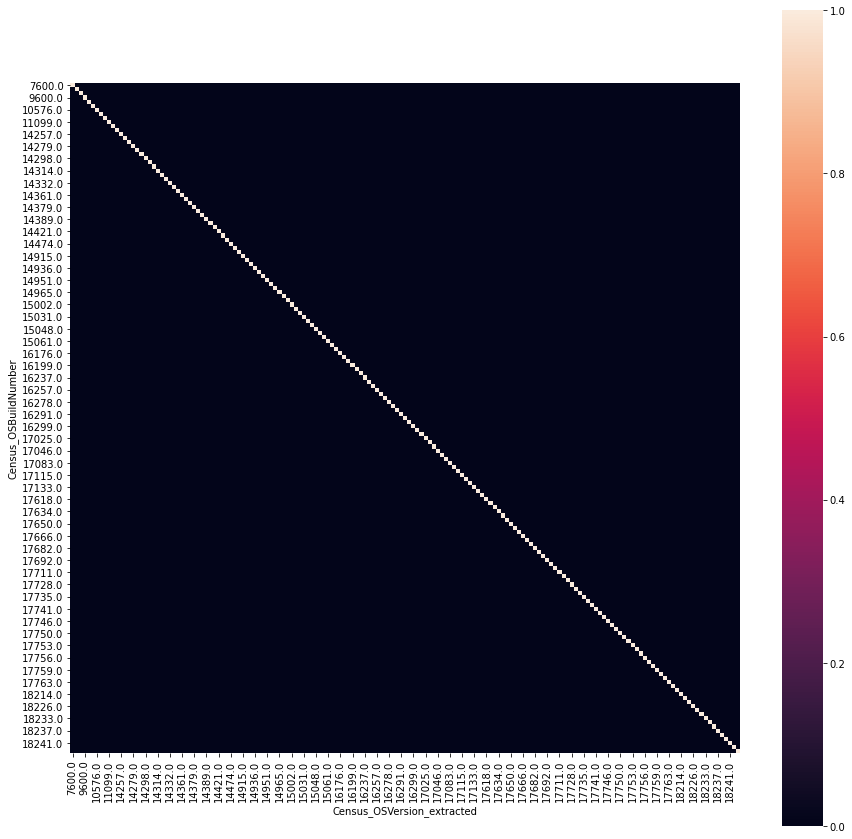

In [61]:
OS_build_contingency = pd.crosstab(df['Census_OSBuildNumber'].astype('float'), 
                                   df['Census_OSVersion_extracted'].astype('float'),
                                  normalize='columns')
plt.figure(figsize=(15,15))
sns.heatmap(OS_build_contingency, square=True)

In [62]:
sum(df['Census_OSBuildNumber'].astype(float) != df['Census_OSVersion_extracted'].astype(float))

0

Census_OSBuildNumber and Census_OSVersion_extracted are the same and differ from OsBuild for ~5% of the entries. Let's add them to the drop list.

In [66]:
to_drop = to_drop + ['Census_OSVersion_extracted', 'Census_OSBuildNumber']

In [67]:
def compare_feature(col_name):
    ''' 
    Reads column name (str). 
    Returns a df summarizing comparing original and 
    extracted features, a list of tuples containing the 
    different element, and the count of different elements
    '''
    df_1 = pd.DataFrame(df[df[col_name] != temp_df[col_name]][['OsBuildLab', col_name]].values, columns=['OsBuildLab', col_name+'1'])
    df_2 = pd.DataFrame(temp_df[df[col_name] != temp_df[col_name]][col_name].values, columns=[col_name+'2'])
    comparison_df = pd.concat([df_1, df_2], axis=1)
    comp_list = list(zip(comparison_df.iloc[:, 1], comparison_df.iloc[:, 2]))

    return comparison_df, comp_list, Counter(comp_list)

In [68]:
comparison_df, comp_list, tuple_counts = compare_feature('OsPlatformSubRelease')

In [69]:
comparison_df.head()

,OsBuildLab,OsPlatformSubRelease1,OsPlatformSubRelease2
0,7601.18409.amd64fre.win7sp1_gdr.140303-2144,windows7,win7sp1
1,9600.19067.x86fre.winblue_ltsb_escrow.180619-2033,windows8.1,winblue
2,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,windows8.1,winblue
3,9600.19125.amd64fre.winblue_ltsb.180812-0703,windows8.1,winblue
4,9600.19000.amd64fre.winblue_ltsb.180410-0600,windows8.1,winblue


In [70]:
tuple_counts

Counter({('windows7', 'win7sp1'): 93308,
         ('windows8.1', 'winblue'): 194498,
         ('prers5', 'rs5'): 15015,
         ('prers5', 'rs'): 5976,
         ('windows7', 'win7'): 581,
         ('rs4', 'rs1'): 12,
         ('rs4', 'rs3'): 2,
         ('rs4', nan): 7,
         ('windows8.1', nan): 9,
         ('rs3', nan): 5,
         ('rs3', 'rs1'): 1,
         ('prers5', 'rs4'): 1,
         ('rs4', 'rs6'): 1,
         ('windows8.1', 'rs4'): 1})

It looks like the values are consistent.

In [71]:
comparison_df, comp_list, tuple_counts = compare_feature('Census_OSArchitecture')
tuple_counts

Counter({('x86', 'amd64'): 7619,
         ('amd64', 'x86'): 8069,
         ('x86', nan): 2,
         ('amd64', nan): 19})

It looks like the the 64 and 32 bits are switched occasionally.

In [72]:
comparison_df, comp_list, tuple_counts = compare_feature('Census_OSBranch')
comparison_df

,OsBuildLab,Census_OSBranch1,Census_OSBranch2
0,7601.18409.amd64fre.win7sp1_gdr.140303-2144,th2_release,win7sp1_gdr
1,16299.431.amd64fre.rs3_release_svc_escrow.1805...,rs4_release,rs3_release_svc_escrow
2,9600.19067.x86fre.winblue_ltsb_escrow.180619-2033,rs1_release,winblue_ltsb_escrow
3,10240.17914.amd64fre.th1.180627-1911,th1_st1,th1
4,14393.576.x86fre.rs1_release_inmarket.161208-2252,rs1_release,rs1_release_inmarket
...,...,...,...
1041344,14393.576.amd64fre.rs1_release_inmarket.161208...,rs1_release,rs1_release_inmarket
1041345,9600.19101.amd64fre.winblue_ltsb_escrow.180718...,rs4_release,winblue_ltsb_escrow
1041346,9600.17630.amd64fre.winblue_r7.150109-2022,th2_release,winblue_r7
1041347,10240.17443.amd64fre.th1.170602-2340,th1_st1,th1


In [73]:
tuple_counts

Counter({('th2_release', 'win7sp1_gdr'): 1649,
         ('rs4_release', 'rs3_release_svc_escrow'): 42896,
         ('rs1_release', 'winblue_ltsb_escrow'): 31252,
         ('th1_st1', 'th1'): 179636,
         ('rs1_release', 'rs1_release_inmarket'): 105908,
         ('th2_release', 'winblue_ltsb_escrow'): 72699,
         ('th2_release', 'winblue_ltsb'): 32634,
         ('th2_release', 'th2_release_sec'): 71601,
         ('rs3_release_svc_escrow', 'rs3_release'): 12335,
         ('rs4_release', 'rs3_release'): 46023,
         ('th2_release', 'th2_release_inmarket'): 4355,
         ('rs1_release', 'rs1_release_sec'): 36354,
         ('rs1_release', 'rs1_release_1'): 41670,
         ('th2_release', 'win7sp1_ldr'): 36923,
         ('th2_release', 'win7sp1_ldr_escrow'): 27165,
         ('rs3_release', 'rs3_release_svc_escrow'): 35884,
         ('rs3_release', 'rs3_release_svc'): 45527,
         ('rs4_release', 'rs2_release'): 4645,
         ('th1', 'th1_st1'): 3435,
         ('rs1_release', 

There are more incosistencies here, I will extract **branch release** from **OsBuildLab** for further processing. The other eeatures extracted from **OsBuildLab** are actually already present in the dataset. Hence, after extracting the **branch release** I can drop **OsBuildLab**.

In [74]:
df['Census_OSBranch_release_extracted'] = df.OsBuildLab.str.split('.').str.get(3)
df['Census_OSBranch_release_extracted'] = df['Census_OSBranch_release_extracted'].astype('category')
df['Census_OSBranch_release_extracted']

0                     rs4_release
1                     rs4_release
2                     rs4_release
3                     rs4_release
4                     rs4_release
                    ...          
8921478    rs3_release_svc_escrow
8921479           th2_release_sec
8921480               rs3_release
8921481               rs2_release
8921482               rs4_release
Name: Census_OSBranch_release_extracted, Length: 8921483, dtype: category
Categories (51, object): ['rs1_release', 'rs1_release_1', 'rs1_release_d', 'rs1_release_inmarket', ..., 'winblue_r7', 'winblue_r8', 'winblue_r9', 'winblue_rtm']

In [75]:
to_drop.append('OsBuildLab')

There are still a couple possible redundancies in the data.

In [76]:
to_drop

['AvSigVersion',
 'Census_OSVersion',
 'AppVersion',
 'EngineVersion',
 'OsVer',
 'Census_OSVersion_extracted',
 'Census_OSBuildNumber',
 'OsBuildLab']

**Census_OSBranch** and **OsPlatformSubRelease**  likely carry same info:

In [77]:
df[df.Census_OSBranch.astype('object') != df.OsPlatformSubRelease.astype('object')][['Census_OSBranch', 'OsPlatformSubRelease']]

,Census_OSBranch,OsPlatformSubRelease
0,rs4_release,rs4
1,rs4_release,rs4
2,rs4_release,rs4
3,rs4_release,rs4
4,rs4_release,rs4
...,...,...
8921478,rs3_release_svc_escrow,rs3
8921479,th2_release_sec,th2
8921480,rs3_release,rs3
8921481,rs2_release,rs2


In [78]:
np.mean(df.Census_OSBranch.astype('object').str.split('_').str.get(0) != df.OsPlatformSubRelease.astype('object'))

0.05193744134243152

In [79]:
df[['Census_OSBranch', 'OsPlatformSubRelease']][df.Census_OSBranch.astype('object').str.split('_').str.get(0) != df.OsPlatformSubRelease.astype('object')]

,Census_OSBranch,OsPlatformSubRelease
16,th2_release,windows7
17,rs4_release,rs3
20,rs1_release,windows8.1
41,th2_release,windows8.1
49,th2_release,windows8.1
...,...,...
8921400,th2_release,windows7
8921442,rs4_release,windows8.1
8921452,th2_release,windows8.1
8921457,rs5_release,prers5


In [82]:
to_drop.append('Census_OSBranch')

In [83]:
to_drop

['AvSigVersion',
 'Census_OSVersion',
 'AppVersion',
 'EngineVersion',
 'OsVer',
 'Census_OSVersion_extracted',
 'Census_OSBuildNumber',
 'OsBuildLab',
 'Census_OSBranch']

In [84]:
df = df.drop(to_drop, axis=1)

In [85]:
df.shape

(8921483, 72)

In [86]:
cat_col = df.select_dtypes('category').columns.tolist()
cat_col 

['ProductName',
 'Platform',
 'Processor',
 'OsPlatformSubRelease',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSArchitecture',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing',
 'AvSigVersion_extracted',
 'AppVersion_extracted',
 'EngineVersion_extracted',
 'OsVer_encoded',
 'Census_OSBranch_release_extracted']

# Numerical features

In [87]:
num_col = [col for col in df.columns.tolist() if col not in cat_col]
df[num_col].head()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,628.0,36144.0,0,0.0,0,0,0.0,0.0,10.0,0
1,0,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,628.0,57858.0,0,0.0,0,0,0.0,0.0,8.0,0
2,0,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,142.0,52682.0,0,0.0,0,0,0.0,0.0,3.0,0
3,0,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,355.0,20050.0,0,0.0,0,0,0.0,0.0,3.0,1
4,0,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,355.0,19844.0,0,0.0,0,0,0.0,0.0,1.0,1


In [88]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
IsBeta,8921483.0,7.509962e-06,2.740421e-03,0.000000,0.000000,0.0,0.000000e+00,1.000000e+00
RtpStateBitfield,8889165.0,NaN,0.000000e+00,0.000000,7.000000,7.0,7.000000e+00,3.500000e+01
IsSxsPassiveMode,8921483.0,1.733378e-02,1.305118e-01,0.000000,0.000000,0.0,0.000000e+00,1.000000e+00
AVProductStatesIdentifier,8885262.0,4.784002e+04,1.403237e+04,3.000000,49480.000000,53447.0,5.344700e+04,7.050700e+04
AVProductsInstalled,8885262.0,NaN,0.000000e+00,0.000000,1.000000,1.0,2.000000e+00,7.000000e+00
AVProductsEnabled,8885262.0,NaN,0.000000e+00,0.000000,1.000000,1.0,1.000000e+00,5.000000e+00
HasTpm,8921483.0,9.879711e-01,1.090149e-01,0.000000,1.000000,1.0,1.000000e+00,1.000000e+00
CountryIdentifier,8921483.0,1.080490e+02,6.304706e+01,1.000000,51.000000,97.0,1.620000e+02,2.220000e+02
CityIdentifier,8596074.0,8.126650e+04,4.892339e+04,5.000000,36825.000000,82373.0,1.237000e+05,1.679620e+05
OrganizationIdentifier,6169965.0,NaN,0.000000e+00,1.000000,18.000000,27.0,2.700000e+01,5.200000e+01


In [89]:
df.IsProtected.unique()

array([ 1.,  0., nan], dtype=float16)

IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.

Change encoding:

In [90]:
df.IsProtected = df.IsProtected.map({np.nan:0, 0:1, 1:2})
df.IsProtected.unique()

array([2, 1, 0], dtype=int64)

In [91]:
df.IsProtected.describe()

count    8.921483e+06
mean     1.937763e+00
std      2.577668e-01
min      0.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: IsProtected, dtype: float64

In [92]:
binary_feat = [col for col in num_col if df[col].nunique() <= 2]
binary_feat

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

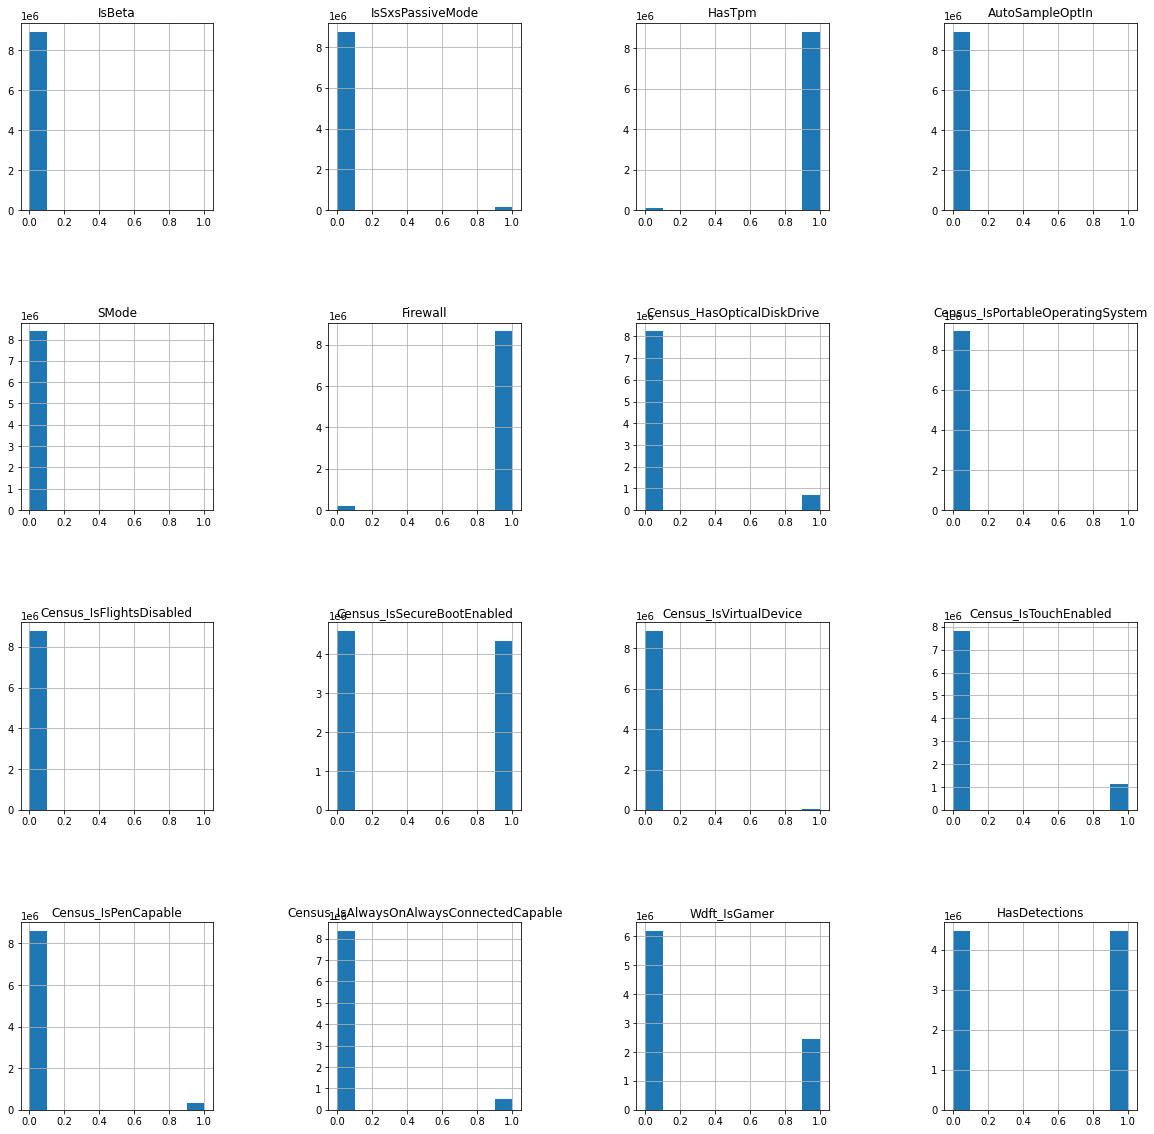

In [93]:
df[binary_feat].hist(figsize=(20, 20))
plt.subplots_adjust(hspace=.6, wspace=.6)

In [ ]:
aaaaaaaaaaaaaaaaaaaaaaaaadddddddddddddddd what to drop
# to_drop =

In [ ]:
df.loc[:, ~df.columns.isin(binary_feat)].hist(figsize=(20, 60), layout=(11, 3))
plt.subplots_adjust(hspace=.5, wspace=.8)

Summary of numerical features and potential issues:
   - **RtpStateBitfield**: no info in metadata. The most frequent value is 7.
   - **AVProductStatesIdentifier**: these are ID's for the specific configuration of a user's antivirus software. Should treat it as categorical feature. Most ID values around 53000.
   - **AVProductsInstalled** and **AVProductsEnabled**: no info in metadata. Probably a count of Anti Virus Products Installed and Enabled. Likely correlated. Most of values are 1 or 2 then large left skew. 
   - **CountryIdentifier**, **CityIdentifier**,  **GeoNameIdentifier**, **LocaleEnglishNameIdentifier**: these are all ID's taking many values and all related to physical location of a machine.
   - **OrganizationIdentifier**: ID for the organization the machine belongs in. Most values are 20 and 30, could reduce to three classes: 20, 30, others.
   - **OsBuild** and **OsSuite**: these are again ID's of Product build and suite mask for the current operating system. OsSuite has mainly two classes.
   - **IeVerIdentifier** no info in metadata. Might have outliers  for values > 300.
   - **UacLuaenable**: has outliers and/or extremely rare values.
   - **Census_OEMNameIdentifier**, **Census_OEMModelIdentifier**: no info in metadata. Should be ID for original equipment manufacturer OEM name and model.
   - **Census_ProcessorCoreCount**: Actual number of logical cores in the processor. Most machines have < 20 cores. There are outliers maybe because of supercomputers.
   - **Census_ProcessorManufacturerIdentifier**, **Census_ProcessorModelIdentifier**: no info in metadata. Should be ID for processor manufacturer and model.
   - **Census_PrimaryDiskTotalCapacity**, **Census_SystemVolumeTotalCapacity**, **Census_TotalPhysicalRAM**: these are actual numerics in MB of memory. They are likely correlated and have outliers.
   - **Census_InternalPrimaryDiagonalDisplaySizeInInches**, **Census_InternalPrimaryDisplayResolutionHorizontal**, **Census_InternalPrimaryDisplayResolutionVertical**: these are dims and resolution of display. Should not be correlated with malware infections. Contain outliers.
   - **Census_InternalBatteryNumberOfCharges**: no info in metadata. It has mostly very small or very big values. Might convert it to binary feature.
   - All features with "OS" or "Os", i.e. those related to Operating System, present repetitions since some have been extracted from **OsVer** and **OsBuildLab**. I will need to drop these repetitions.
   - **Census_FirmwareManufacturerIdentifier**, **Census_FirmwareVersionIdentifier**no info in metadata. Should be ID's of Firmware Manufacturer and version.
   - **Wdft_RegionIdentifier**: no info in metadata. Should be another ID.
   
    Key points:
    1. Many features have outliers / extremely skewed distributions  
    2. A few features are repeted / duplicates of other categorical features - see OS features
    3. Most of the numerical features are actually categories / ID's encoded as numbers
    4. Actual numerical features are: 
        - Census_ProcessorCoreCount
        - Census_PrimaryDiskTotalCapacity
        - Census_SystemVolumeTotalCapacity
        - Census_TotalPhysicalRAM
        - Census_InternalPrimaryDiagonalDisplaySizeInInches
        - Census_InternalPrimaryDisplayResolutionHorizontal
        - Census_InternalPrimaryDisplayResolutionVertical
        - Census_InternalBatteryNumberOfCharges

Let's fix some of this problems, starting with checking obvious outliers and extremely skewed distributions. I will add the features which are not usefull to the analysis to the list to_drop and fix outliers for the other features which may have predictive power.

**RtpStateBitfiels**

In [ ]:
pd.crosstab(df.RtpStateBitfield, df.HasDetections, margins=True)

**UacLuaenable**

In [ ]:
pd.crosstab(df.UacLuaenable, df.HasDetections, margins=True)

In [ ]:
to_drop.append('UacLuaenable')

**AVProductsEnabled**

In [ ]:
pd.crosstab(df.AVProductsEnabled, df.HasDetections, margins=True) 

**Census_ProcessorCoreCount**

In [ ]:
df.Census_ProcessorCoreCount.hist(bins=50)

Contains outliers.

In [ ]:
pd.crosstab(df.Census_ProcessorCoreCount, df.HasDetections, margins=True) 

Very few machines have more than 16 cores. 

**Census_PrimaryDiskTotalCapacity**

In [ ]:
df.Census_PrimaryDiskTotalCapacity.hist(bins=30)

Contains outliers.

Use 16 TB = 16 $\times$ 10$^{6}$ MB as limit for outliers

In [ ]:
limit = 16*10**6
df.loc[df['Census_PrimaryDiskTotalCapacity'] > limit, 'Census_PrimaryDiskTotalCapacity']

In [ ]:
df.loc[df['Census_PrimaryDiskTotalCapacity'] > limit, 'Census_PrimaryDiskTotalCapacity'] = np.nan
df.Census_PrimaryDiskTotalCapacity.hist(bins=30)

Still contains outliers.

**Census_SystemVolumeTotalCapacity**

In [ ]:
df.Census_SystemVolumeTotalCapacity.hist(bins=30)

Contains outliers.

In [ ]:
vol_limit = 2e6
df.loc[df['Census_SystemVolumeTotalCapacity'] > vol_limit, 'Census_SystemVolumeTotalCapacity'] = np.nan
df.Census_SystemVolumeTotalCapacity.hist(bins=30)

**Census_TotalPhysicalRAM**

In [ ]:
df.Census_TotalPhysicalRAM.hist(bins=30)

Contains outliers.

In [ ]:
df.Census_TotalPhysicalRAM.value_counts()

In [ ]:
bins = [0,
        2_000,
        4_000,
        8_000,
        16_000,
        32_000,
        64_000,
        128_000,
        192_000,
        512_000,
        1_000_000,
        np.inf]
labels = ['0-2 GB', '2-4 GB', '4-8 GB', '8-16 GB',
          '16-32 GB', '32-64 GB', '64-128 GB', 
          '128-192 GB',  '192-512 GB', '512-1000 GB', 
          '1+ TB']

RAM_bins_df = pd.cut(df.Census_TotalPhysicalRAM,
                     bins=bins,
                     labels=labels)
RAM_bins_df.value_counts()

In [ ]:
df.Census_TotalPhysicalRAM.max()

Max of about 1 TB is possible for RAM of Windows Servers

**Census_InternalPrimaryDiagonalDisplaySizeInInches**

In [ ]:
df.Census_InternalPrimaryDiagonalDisplaySizeInInches.hist(bins=30)

Screens with diagonal > 80 inches are rare but a max of 140 inches is possible. Will keep it as is. 

**Census_InternalPrimaryDisplayResolutionHorizontal** and **Census_InternalPrimaryDisplayResolutionVertical**

In [ ]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.hist(bins=30)

In [ ]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.max()

In [ ]:
df.Census_InternalPrimaryDisplayResolutionVertical.hist(bins=30)

In [ ]:
resolution = ['Census_InternalPrimaryDisplayResolutionHorizontal', 
              'Census_InternalPrimaryDisplayResolutionVertical']
df[df.Census_InternalPrimaryDisplayResolutionHorizontal >5240][resolution]

Index 29779 with 7680.0 pixels is a possible value. Keep it for now. 

**Census_InternalBatteryNumberOfCharges**

In [ ]:
df.Census_InternalBatteryNumberOfCharges.hist(bins=30)

In [ ]:
battery_charges_count = df.Census_InternalBatteryNumberOfCharges.value_counts()
battery_charges_count[:20]

There is no info about this column, and most values are 0 or 4e9. 

In [ ]:
df.shape

In [ ]:
df.to_csv('../data/interim/train_clean.csv', index = False)